In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from collections import Counter as ct
plt.rcParams['figure.figsize'] = (8,5)
%matplotlib inline

In [2]:
data_train = pd.read_csv('../nikhil/Desktop/practice/train.csv')
data_test = pd.read_csv('../nikhil/Desktop/practice/test.csv')

In [3]:
# For describing numerical columns and drawing histograms
def descr(x):
    la = x.columns[x.isnull().any()].tolist()
    data_train_numeric_col = x._get_numeric_data().columns.tolist()
    df_cols = []
    for i in la:
        if i in data_train_numeric_col:
            df_cols.append(i)
            b = x[i].isnull().value_counts()
            print("Name of Column", i + ":\nNumber of Null values:\n",b)
    df = x[df_cols]
    print(df.describe())
    return df.hist()

Name of Column LotFrontage:
Number of Null values:
 False    1201
True      259
Name: LotFrontage, dtype: int64
Name of Column MasVnrArea:
Number of Null values:
 False    1452
True        8
Name: MasVnrArea, dtype: int64
Name of Column GarageYrBlt:
Number of Null values:
 False    1379
True       81
Name: GarageYrBlt, dtype: int64
       LotFrontage   MasVnrArea  GarageYrBlt
count  1201.000000  1452.000000  1379.000000
mean     70.049958   103.685262  1978.506164
std      24.284752   181.066207    24.689725
min      21.000000     0.000000  1900.000000
25%      59.000000     0.000000  1961.000000
50%      69.000000     0.000000  1980.000000
75%      80.000000   166.000000  2002.000000
max     313.000000  1600.000000  2010.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d0c298a58>,
      dtype=object)

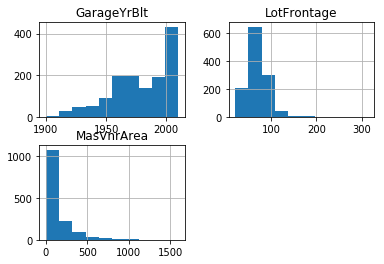

In [4]:
descr(data_train)

In [5]:
# For Na value filling of MasVnrArea column
def fill_na_mean(x, y):
    x[y] = x[y].fillna(np.round(np.mean(x[y])))

In [6]:
fill_na_mean(data_train, 'MasVnrArea')

In [7]:
# For filling na with range of random values
def fill_na_range(A, B, x,y):
    a = range(x,y)
    c = A[B].isnull()
    A[B] = A[B].fillna(pd.Series(np.random.choice(a, size=A.shape[0])))

In [8]:
fill_na_range(data_train, 'LotFrontage', 50, 100)

In [9]:
fill_na_range(data_train, 'GarageYrBlt', 1960, 2000)

In [10]:
#rand_range = [i for i in range(40,100)]
#data_train['LotFrontage'] = data_train['LotFrontage'].fillna(pd.Series(np.random.choice(rand_range,size=data_train.shape[0])))

In [11]:
# To check the Na values
def is_na(x,y):
    return x[y].isnull().value_counts()

is_na(data_train,'GarageYrBlt')

False    1460
Name: GarageYrBlt, dtype: int64

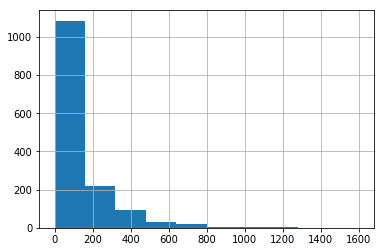

In [12]:
data_train.MasVnrArea.hist()

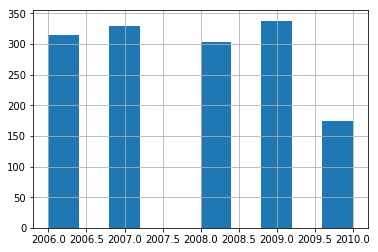

In [13]:
data_train.YrSold.hist()

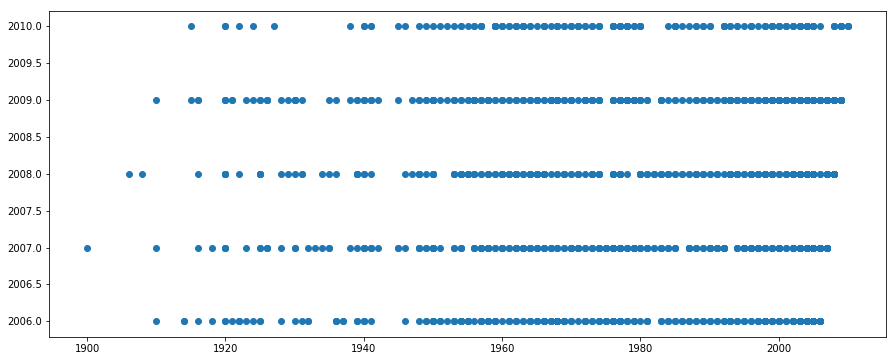

In [14]:
# Here we are checking if filled GarageYrBlt na values are not greater than YrSold
#(data_train.YearBuilt > data_train.YrSold).value_counts()
plt.figure(figsize=(15,6))
plt.scatter(data_train.GarageYrBlt, data_train.YrSold)

In [15]:
data_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [16]:
(data_train.YearRemodAdd > data_train.YrSold).value_counts()

False    1459
True        1
dtype: int64

In [17]:
# This data point does not affect sale price
# We shall handle this situation by taking only positive value.
y = data_train[(data_train.YearRemodAdd > data_train.YrSold)]
y[['YearRemodAdd', 'YrSold']]

,YearRemodAdd,YrSold
523,2008,2007


In [18]:
(data_train.YearRemodAdd < data_train.YearBuilt).value_counts()

False    1460
dtype: int64

In [19]:
data_train['buit_sold_diff'] = data_train.YrSold - data_train.YearBuilt
data_train['built_remod_diff'] = data_train.YearRemodAdd - data_train.YearBuilt
data_train['remod_sold_diff'] = data_train.YrSold - data_train.YearRemodAdd

In [20]:
# Categorical columns
columns = data_train.columns
numeric_cols = data_train._get_numeric_data().columns
categorical_cols = list(set(columns) - set(numeric_cols))

In [21]:
# Here we are checking if there are any columns with only binary values
binary_cols = []
for i in categorical_cols:
    if data_train[i].nunique() == 2:
        binary_cols.append(i)
        print(i)

Utilities
CentralAir
Alley
Street


In [22]:
# Equivalent to --->data_train['CentralAir'] = np.where(data_train['CentralAir'] == 'Y', 1, data_train['CentralAir'])
# --->data_train['CentralAir'] = np.where(data_train['CentralAir'] == 'N', 0, data_train['CentralAir'])
# We are doing this to reduce number of features

def binary_coding(a, b):
    a[b] = np.where(a[b] == a[b].unique()[0], 1, a[b])
    a[b] = np.where(a[b] == a[b].unique()[1], 0, a[b])

In [23]:
binary_coding(data_train, 'Street')
binary_coding(data_train, 'CentralAir')
binary_coding(data_train, 'Utilities')

In [24]:
for i in binary_cols:
    if i != 'Alley':
        categorical_cols.remove(i)

In [25]:
# We have checked if any row is a duplicate of any other row
data_train[data_train.duplicated(keep=False)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,buit_sold_diff,built_remod_diff,remod_sold_diff


In [26]:
del data_train['YearBuilt']
del data_train['YrSold']
del data_train['YearRemodAdd']
del data_train['Id']

In [27]:
dummy_data = pd.get_dummies(data=data_train, columns=categorical_cols)

In [28]:
dummy_data.head()

,MSSubClass,LotFrontage,LotArea,Street,Utilities,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Electrical_SBrkr,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No
0,60,65.0,8450,1,1,7,5,196.0,706,0,...,1,0,0,0,0,1,0,0,0,1
1,20,80.0,9600,1,1,6,8,0.0,978,0,...,1,0,0,0,0,1,0,1,0,0
2,60,68.0,11250,1,1,7,5,162.0,486,0,...,1,0,0,0,0,1,0,0,1,0
3,70,60.0,9550,1,1,7,5,0.0,216,0,...,1,0,0,0,0,1,0,0,0,1
4,60,84.0,14260,1,1,8,5,350.0,655,0,...,1,0,0,0,0,1,1,0,0,0


In [29]:
dummy_data[dummy_data['remod_sold_diff'] == -1]

,MSSubClass,LotFrontage,LotArea,Street,Utilities,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Electrical_SBrkr,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No
523,60,130.0,40094,1,1,10,5,762.0,2260,0,...,1,0,0,0,0,1,0,1,0,0


In [30]:
dummy_data['remod_sold_diff'] = np.absolute(dummy_data['remod_sold_diff'])

In [31]:
# So we have successfully converted our data to numerical form, suitable for regression
# There are no na values.
dummy_data.isnull().any().value_counts()

False    286
dtype: int64

In [32]:
y = dummy_data[['SalePrice']]
del dummy_data['SalePrice']
x = dummy_data

In [33]:
lm = LinearRegression()
model = lm.fit(x, y)

In [34]:
lm.predict(x)[:15]

array([[207894.33413196],
       [204195.37237078],
       [206195.47504427],
       [165488.08032857],
       [288718.56428019],
       [148911.58201261],
       [280045.90346338],
       [228391.25791552],
       [135639.15978804],
       [117348.11384885],
       [136774.54048478],
       [397043.70992419],
       [136841.02341703],
       [230049.83884301],
       [150846.89584817]])

In [35]:
lm.score(x, y)

0.9410950620754175

In [36]:
lm.coef_

array([[-4.38100141e+01,  3.97926484e+01,  7.98108103e-01,
         3.35587176e+04,  2.85617408e+04,  6.33421484e+03,
         5.94176543e+03,  1.93959491e+01,  1.76505286e+01,
         8.44284777e+00, -1.01172233e+00,  2.50815383e+01,
         1.02933082e+02,  1.94168807e+01,  3.83977056e+01,
        -2.63578295e+01,  3.14567301e+01,  1.06547331e+03,
        -4.63995766e+02,  3.23645101e+03,  1.54632691e+03,
        -4.58488968e+03, -1.39542406e+04,  1.32337317e+03,
         4.54981994e+03, -3.37659182e-02,  5.09092873e+03,
         8.94004799e+00,  1.43304814e+01,  1.19981408e+01,
         3.19093547e+00,  2.91118575e+01,  3.47987226e+01,
         6.28989881e+02,  1.27012837e+00, -3.53110198e+02,
         2.03668935e+05, -2.04033451e+05, -2.04134843e+05,
         2.69319772e+04,  1.40242039e+04,  2.45601784e+04,
         1.23554405e+04,  1.58899646e+04,  1.78780064e+04,
        -4.39683732e+03, -5.96257906e+03, -3.92978933e+03,
        -7.35688398e+03,  4.94933531e+03,  5.74256651e+0

In [37]:
lm.intercept_

array([-136222.54610726])

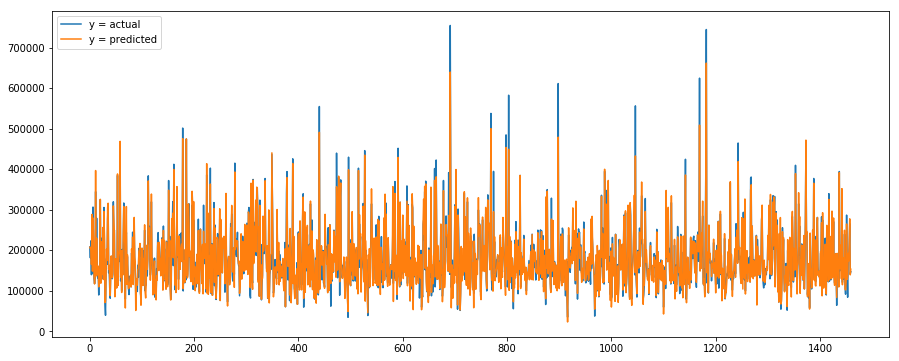

In [40]:
plt.figure(figsize=(15,6))
plt.plot(y.SalePrice)
plt.plot(lm.predict(x))
plt.legend(['y = actual', 'y = predicted'], loc = 'upper left')
plt.show()